In [1]:
import torch

from pulser_diff.pulser import Sequence, Pulse, Register
from pulser_diff.pulser.devices import MockDevice
from pulser_diff.pulser.waveforms import BlackmanWaveform, RampWaveform

from pulser_diff.pulser_simulation import SimConfig

import pulser_diff.dq as dq
from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import deriv_time, deriv_param

from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy import interpolate

`pulser-diff` allows differentiating the result of Schrodinger equation solver with respect to sequence evaluation times or any parameters that define the constituent pulses of the sequence. Differentiation is performed using the auto-differentiation capabilities of the underlying `torch` library.

Let us see, how we can calculate such derivatives. First we define the register.

In [2]:
# define coordinates of 4 qubits as torch tensors
# requires_grad=True instructs the auto-differentiation engine that gradients will be stored for these tensors 
# that will allow derivatives with respect to these parameters be calculated
q0_coords = torch.tensor([0.0, 0.0], requires_grad=True)
q1_coords = torch.tensor([0.0, 8.0], requires_grad=True)
q2_coords = torch.tensor([8.0, 0.0], requires_grad=True)
q3_coords = torch.tensor([8.0, 8.0], requires_grad=True)

# create register
reg = Register({"q0": q0_coords, "q1": q1_coords, "q2": q2_coords, "q3": q3_coords})
print(reg)

Register(_coords=[tensor([0., 0.], requires_grad=True), tensor([0., 8.], requires_grad=True), tensor([8., 0.], requires_grad=True), tensor([8., 8.], requires_grad=True)])


Now we create an empty sequence, define channels and define the parameters of pulses that will be added to the sequence.

In [3]:
# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
start_det = torch.tensor([-5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)
det = torch.tensor([0.0], requires_grad=True)
phase = torch.tensor([0.0], requires_grad=True)

# define time-dependent waveforms
amp_wf = BlackmanWaveform(800, area)
det_wf = RampWaveform(800, start_det, 0.0)

# add pulses
seq.add(Pulse(amp_wf, det_wf, 0), "rydberg_global")
seq.add(Pulse.ConstantPulse(800, omega, det, phase), "rydberg_global")

Note that all pulse parameters above created as tensors are created with `requires_grad=True` argument, however if differentiation with respect to some of them won't be performed, it is beneficial to set `requires_grad=False` for those parameters in order to save memory. 

When creating pulses we can mix `torch` tensors and simple `float` values as pulse parameters.

Sequence simulation is performed using the standard Pulser interface.

In [4]:
sim = TorchEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(time_grad=True, dist_grad=True, progress_bar=True, solver="dq")

|          |  0.0% - time 00:00/?

|██████████| 100.0% - time 00:02/00:00


Argument `time_grad=True` instructs the simulation to store gradients for evaluation times, thus allowing later to calculate derivative of the output with respect to these times. `dist_grad=True` means that we will be able to calculate derivatives with respect to inter-qubit distances. We can also specify, what solver to use for quantum dynamics simulation: `"dq"` - selects the ODE solver from internal `dynamiqs` library, `"krylov"` selects the Krylov subspace method solver.

`results` object contains the values of the system's wavefunction at times stored in the `sim.evaluation_times` tensor. Both of these quantities are `torch` tensors.

In [5]:
print("Evaluation times:")
print(sim.evaluation_times)
print()
print("Wavefunctions:")
print(results.states)

Evaluation times:
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1610, 0.1710,
        0.1810, 0.1910, 0.2010, 0.2110, 0.2210, 0.2310, 0.2410, 0.2510, 0.2610,
        0.2710, 0.2810, 0.2910, 0.3010, 0.3110, 0.3220, 0.3320, 0.3420, 0.3520,
        0.3620, 0.3720, 0.3820, 0.3920, 0.4020, 0.4120, 0.4220, 0.4320, 0.4420,
        0.4520, 0.4620, 0.4720, 0.4830, 0.4930, 0.5030, 0.5130, 0.5230, 0.5330,
        0.5430, 0.5530, 0.5630, 0.5730, 0.5830, 0.5930, 0.6030, 0.6130, 0.6230,
        0.6330, 0.6440, 0.6540, 0.6640, 0.6740, 0.6840, 0.6940, 0.7040, 0.7140,
        0.7240, 0.7340, 0.7440, 0.7540, 0.7640, 0.7740, 0.7840, 0.7940, 0.8050,
        0.8150, 0.8250, 0.8350, 0.8450, 0.8550, 0.8650, 0.8750, 0.8850, 0.8950,
        0.9050, 0.9150, 0.9250, 0.9350, 0.9450, 0.9550, 0.9660, 0.9760, 0.9860,
        0.9960, 1.0060, 1.0160, 1.0260, 1.0360, 1.0460, 1.0560, 1.0660, 1.0760,
        1.0860, 1.0960

Using the `results.states` tensor we can further calculate the necessary quantities, e. g., the expectation values at each evaluation time moment. 

In [6]:
# create total magnetization observable
n_qubits = len(reg._coords)
total_magnetization = []
for i in range(n_qubits):
    tprod = [dq.eye(2) for _ in range(n_qubits)]
    tprod[i] = dq.sigmaz()
    total_magnetization.append(dq.tensprod(*tprod))
total_magnetization = sum(total_magnetization)

print(total_magnetization.shape)
# calculate expectation values
exp_val = results.expect([total_magnetization])[0].real

torch.Size([16, 16])


In the cell above `dq` is the private modified version of public `dynamiqs` [library](https://github.com/dynamiqs/dynamiqs)  that provides the `torch`-based ODE solver and helper functions for creating quantum mechanical operators.

### Calculating derivative with respect to time

To calculate derivative with respect to time we get the evaluation times tensor and use `deriv_time` function.

In [7]:
# calculate derivative
eval_times = sim.evaluation_times
pulse_endtimes = sim.endtimes
grad_time = deriv_time(f=exp_val, times=eval_times, pulse_endtimes=pulse_endtimes)

The last argument `pulse_endtimes` to function `deriv_time` is used to provide the indices of pulse start/end times in the `eval_times` tensor. This is needed to fix possible spikes of derivative on the boundary between two ideal pulses.

In order to check that the calculated time derivative is correct we can create an interpolated function from expectation values using `scipy.interpolate` and find the corresponding derivative.

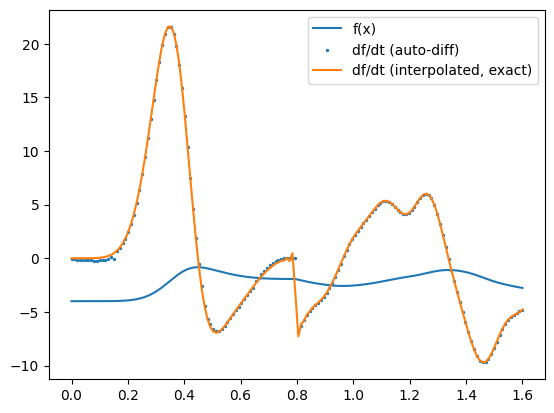

In [8]:
# calculate exact derivative with respect to time
x = eval_times.detach().numpy()
y = exp_val.detach().numpy()
interp_fx = interpolate.UnivariateSpline(x, y, k=5, s=0)
dfdt_exact = interp_fx.derivative()(x)

# visualize expectation values and time derivatives
plt.plot(x, y, label="f(x)")
plt.scatter(x, grad_time.detach().numpy(), s=2, label="df/dt (auto-diff)")
plt.plot(x, dfdt_exact, label="df/dt (interpolated, exact)")
plt.legend()

We can see that time derivative calculated using `torch` auto-differentiation engine closely corresponds to the exact derivative.

### Calculating derivative with respect to pulse/register parameters

The workflow is generally the same as when calculating time derivative only now we will use function `deriv_param` provided by `pulser-diff`.

Let us calculate derivatives of expectation value with respect to amplitude `omega` of the second constant pulse of the sequence, to coordinates of qubit `q1` and inter-qubit distance `r` between qubits `q1` and `q3`. We can obtain all these derivative values by passing the necessary parameters to `deriv_param` in a single list.

In [9]:
# create tensor of times (in ns) where derivative will be evaluated
times = torch.linspace(0.0, 1600, 40)

# we want to calculate derivative with respect to distance between qubits q0 and q3
qq_distances = sim.qq_distances
r = qq_distances["q0-q3"]

# calculate derivative values at each time
diff_params = [omega, q1_coords, r]
grads = []
for t in tqdm(times):
    grad_param = deriv_param(f=exp_val, x=diff_params, times=eval_times, t=t)
    grads.append(torch.hstack(grad_param))
grads = torch.stack(grads)



100%|██████████| 40/40 [00:42<00:00,  1.07s/it]


Similarly we can calculate derivatives with respect to qubit coordinates.

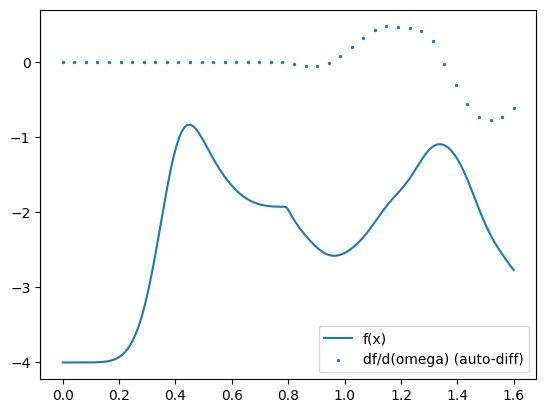

In [10]:
# visualize derivative with respect to amplitude
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:,0].numpy(), s=2, label="df/d(omega) (auto-diff)")
plt.legend()

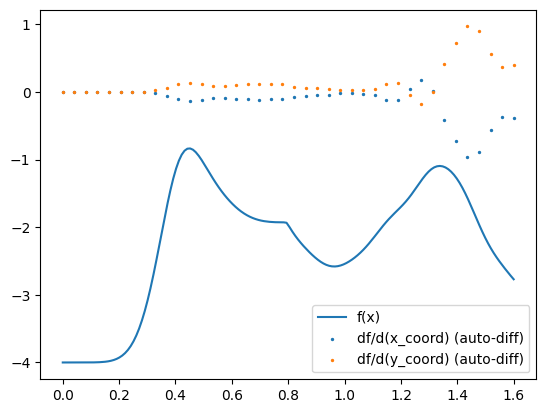

In [11]:
# visualize derivatives with respect to coordinates
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:,1].numpy(), s=2, label="df/d(x_coord) (auto-diff)")
plt.scatter(times.numpy()/1000, grads[:,2].numpy(), s=2, label="df/d(y_coord) (auto-diff)")
plt.legend()

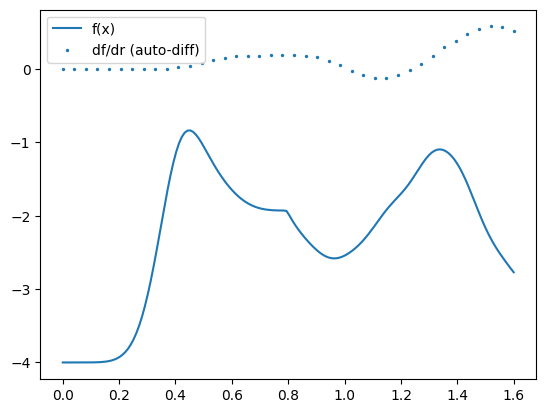

In [12]:
# visualize derivative with repsect to inter-qubit distance
plt.plot(x, y, label="f(x)")
plt.scatter(times.numpy()/1000, grads[:, 3].numpy(), s=2, label="df/dr (auto-diff)")
plt.legend()